# Warm Up - Grid Search

#### Because everyone loves exhaustively searching parameter spaces

So far we have not done any hyperparameter tuning yet, so we will do some now with sklearn's GridSearch functionality

## Dependencies

same as before but now we are also bringing in `GridSearch`

In [3]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("bright", 8))

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

Load the dataset

In [5]:
features, labels = sklearn.datasets.load_breast_cancer(return_X_y=True)

Setup our train function, which is now called `tune`

We are still doing KFold CV here but notice that we have lost the loop! `GridSearchCV` is now in charge of looping and scheduling our runs

In [47]:
def tune(X, y,         # Our data as before 
         param_grid,   # Our search parameters
         cv=None,      # A CV strategy of our choice
         n_jobs=None): # number of parallel jobs 

    # as before except not parameterised
    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(
                random_state=42 # we only set the random state!
            )
        )
    
    grid_search = GridSearchCV(pipeline,
                           param_grid,
                           scoring='f1_micro',
                           cv=cv,
                           n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

Previously we used 
```
pipeline = make_pipeline(RobustScaler(),
                          RandomForestClassifier(
                              n_estimators=15,
                              criterion="entropy",
                              max_features="auto",
                              bootstrap=True,
                              random_state=42))
```

## time to search

In [66]:
from pprint import pprint
import time

# setup a parameter grid, other possible params
#
# criterion              {“gini”, “entropy”}, default=”gini”
# max_depth              int, default=None
# min_samples_leaf       int or float, default=1
# max_features           “auto”, “sqrt”, “log2”}, int or float, default=”auto”
# bootstrap              bool, default=True
#
param_grid = {
  'randomforestclassifier__n_estimators': [1,5,15,50,100]
}


# run the grid search
tic = time.perf_counter()
results, best_index = tune(features,
                           labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=3)
toc = time.perf_counter()



def print_some_facts(results, best_index, tic, toc):
    print("K Fold Tuning Results")
    print(f"Elapsed Time {toc - tic:0.4f} seconds")
    print("Best Index", best_index)
    print("Best Param Set:")
    pprint(results["params"][best_index])
    print(f"F1 Score {results['mean_test_score'][best_index]:.4f} +/- {results['std_test_score'][best_index]}")
    
print_some_facts(results, best_index, tic, toc)

K Fold Tuning Results
Elapsed Time 1.3058 seconds
Best Index 4
Best Param Set:
{'randomforestclassifier__n_estimators': 100}
F1 Score 0.9561 +/- 0.02283883380490945


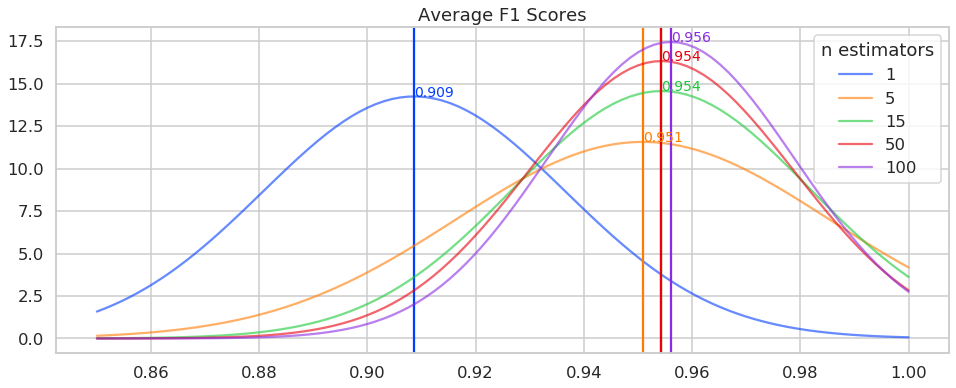

In [67]:
from scipy.stats import norm

def plot_some_results(results):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    mu = results['mean_test_score']
    sigma = results['std_test_score']
    n_estimators = [p["randomforestclassifier__n_estimators"] for p in results["params"]]

    lines = []
    for mu, sigma in zip(results['mean_test_score'], results['std_test_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_results(results)

## Increase the size of the search space

In [68]:
#
# 3D search space - 30 combinations - 150 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=10)
toc = time.perf_counter()

In [69]:
# Take top N models
def take_n_best(x, n):
    idxs = [xx-1 for xx in x["rank_test_score"][:n]]
    y = { k:np.array(v)[idxs] for k,v in x.items() }
    y["rank_test_score"] = list(range(0, len(idxs)))
    return y, 0

In [70]:
print(results["params"][best_index])

{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 100}


K Fold Tuning Results
Elapsed Time 1.7861 seconds
Best Index 19
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9701 +/- 0.011885446954182715


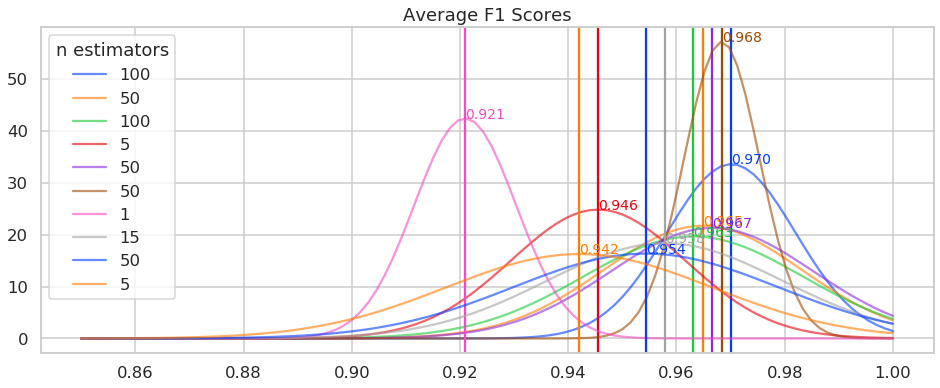

In [71]:
print_some_facts(results, best_index, tic, toc)

top_results, best_index = take_n_best(results, 10)

plot_some_results(top_results)

## Really increase the size of the search space

In [72]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': [1,2,3,4],
    'randomforestclassifier__min_samples_split': [3,4,5,6] 
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=10)
toc = time.perf_counter()

K Fold Tuning Results
Elapsed Time 36.8944 seconds
Best Index 724
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9754 +/- 0.012875287888421138


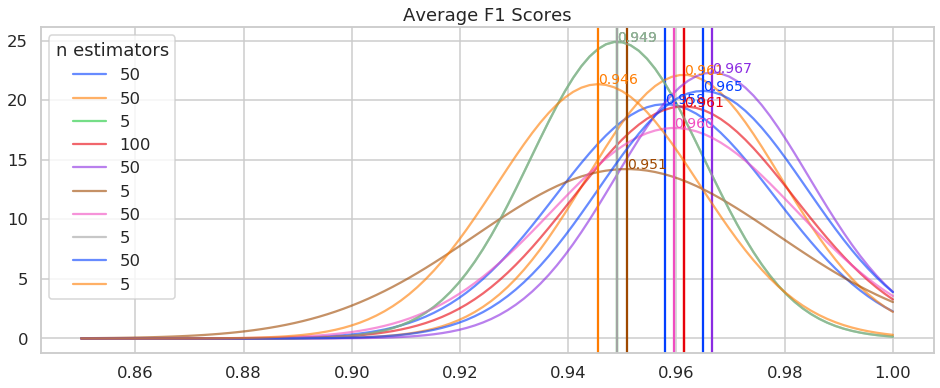

In [75]:
print_some_facts(results, best_index, tic, toc)

top_results, best_index = take_n_best(results, 10)

plot_some_results(top_results)

## Go Random Go!

A better way to search over a large space is to use a different Random Search strategy, and save grid search to fine tune after you are in the ballpark, if you need it

In [76]:
from sklearn.model_selection import RandomizedSearchCV

In [77]:
def rand_tune(X, y, param_dist, n_iter=10,
             cv=None,
             n_jobs=None):

    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(random_state=42)
        )
    
    
    #
    # Same as before, except now we use the RandomizedSearchCV
    #
    grid_search = RandomizedSearchCV(pipeline,
                                   param_dist,
                                   n_iter=n_iter,
                                   scoring='f1_micro',
                                   cv=cv,
                                   n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

In [78]:
import scipy.stats as stats

param_dist = {
    'randomforestclassifier__n_estimators': stats.randint(1,200),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': stats.randint(1,5),
    'randomforestclassifier__min_samples_split': stats.randint(3,6) 
}

In [79]:
tic = time.perf_counter()
results, best_index = rand_tune(features,
                                labels,
                                param_dist,
                                
                                #
                                # Here we set the number of random samples we are attempting
                                #
                                n_iter=100,
                                
                                cv=StratifiedKFold(n_splits=5),
                                n_jobs=10)
toc = time.perf_counter()

K Fold Tuning Results
Elapsed Time 10.7976 seconds
Best Index 0
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 134}
F1 Score 0.9701 +/- 0.019673658351860957


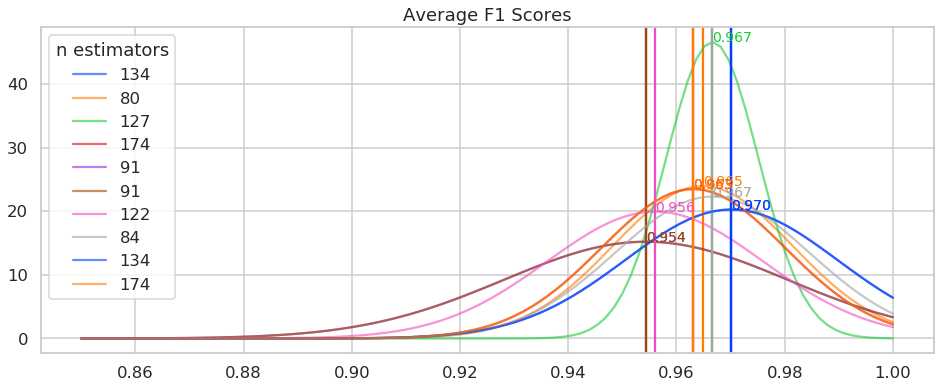

In [80]:
top_results, best_index = take_n_best(results, 10)

print_some_facts(top_results, best_index, tic, toc)
plot_some_results(top_results)

## Takeaway
 
 - Looked at a couple of search strategies
 - We have seen the amount of ccompute scaling even with this simple problem